In [1]:
import re
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
from typing import List, Dict, Set, Tuple
from google.colab import drive
from joblib import dump, load
import graphviz
from IPython.display import display

In [2]:
# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [3]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/ML/Correct spelling/papers.csv')

In [4]:
# Define custom stop words
custom_stop_words = [
    "fig", "figure", "image", "sample", "using",
    "show", "result", "large",
    "also", "one", "two", "three",
    "four", "five", "seven", "eight", "nine"
]

In [5]:
# Get the set of English stop words and add custom stop words
stop_words: Set[str] = set(stopwords.words('english')).union(custom_stop_words)

def pre_process(text: str) -> str:
    """
    Preprocess the input text by applying various cleaning and normalization techniques.

    Args:
        text (str): The input text to be preprocessed.

    Returns:
        str: The preprocessed text.

    This function applies the following preprocessing steps:
    1. Convert to lowercase
    2. Remove HTML tags
    3. Remove special characters and digits
    4. Tokenize the text
    5. Remove stop words
    6. Remove short words (less than 3 characters)
    7. Lemmatize the words
    """
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)

    # Remove special characters and digits
    text = re.sub(r"(\d|\W)+", " ", text)

    # Tokenize the text
    words = text.split()

    # Remove stop words and short words
    words = [word for word in words if word not in stop_words and len(word) >= 3]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [6]:
# Apply preprocessing to all rows
docs = df['paper_text'].apply(pre_process)

print("Sample of preprocessed text:")
print(docs.iloc[0])
print("\nShape of preprocessed data:", docs.shape)

def get_word_count(words: List[str]) -> Dict[str, int]:
    """
    Count the occurrences of each word in the input list.

    Args:
        words (List[str]): A list of words.

    Returns:
        Dict[str, int]: A dictionary where the key is the word and the value is its frequency.
    """
    return Counter(words)

Sample of preprocessed text:
self organization associative database application hisashi suzuki suguru arimoto osaka university toyonaka osaka japan abstract efficient method self organizing associative database proposed together application robot eyesight system proposed database associate input output first half part discussion algorithm self organization proposed aspect hardware produce new style neural network latter half part applicability handwritten letter recognition autonomous mobile robot system demonstrated introduction let mapping given finite infinite set another finite infinite set learning machine observes set pair sampled randomly mean cartesian product computes estimate make small estimation error measure usually say faster decrease estimation error increase number sample better learning machine however expression performance incomplete since lack consideration candidate assumed preliminarily find good learning machine clarify conception let discus type learning machine

In [7]:
# Combine all preprocessed texts and tokenize
all_words = ' '.join(docs).split()

In [8]:
# Get word count
word_count_dict = get_word_count(all_words)

print("\nSample of word counts:")
print(dict(list(word_count_dict.items())[:5]))

def get_probs(word_count_dict: Dict[str, int]) -> Dict[str, float]:
    """
    Calculate the probability of each word based on its frequency.

    Args:
        word_count_dict (Dict[str, int]): A dictionary where the key is the word and the value is its frequency.

    Returns:
        Dict[str, float]: A dictionary where the key is the word and the value is its probability.
    """
    total_words = sum(word_count_dict.values())
    return {word: count / total_words for word, count in word_count_dict.items()}


Sample of word counts:
{'self': 3766, 'organization': 1321, 'associative': 1423, 'database': 3994, 'application': 17552}


In [9]:
# Calculate word probabilities
probs = get_probs(word_count_dict)

print("\nSample of word probabilities:")
print(dict(list(probs.items())[:5]))

def delete_letter(word: str, verbose: bool = False) -> List[str]:
    """
    Generate all possible strings that have one character deleted from the input word.

    Args:
        word (str): The input word.
        verbose (bool): If True, print detailed information about the process.

    Returns:
        List[str]: A list of words with one character deleted.
    """
    split_l = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    delete_l = [L + R[1:] for L, R in split_l if R]

    if verbose:
        print(f"Input word {word}, \nsplit_l = {split_l}, \ndelete_l = {delete_l}")

    return delete_l


Sample of word probabilities:
{'self': 0.00023627943336854102, 'organization': 8.287974813591149e-05, 'associative': 8.927924420696598e-05, 'database': 0.00025058418929207457, 'application': 0.001101215245481846}


In [10]:
def switch_letter(word: str, verbose: bool = False) -> List[str]:
    """
    Generate all possible strings that have two adjacent characters switched.

    Args:
        word (str): The input word.
        verbose (bool): If True, print detailed information about the process.

    Returns:
        List[str]: A list of words with adjacent characters switched.
    """
    split_l = [(word[:i], word[i:]) for i in range(len(word))]
    switch_l = [a + b[1] + b[0] + b[2:] for a, b in split_l if len(b) >= 2]

    if verbose:
        print(f"Input word = {word} \nsplit_l = {split_l} \nswitch_l = {switch_l}")

    return switch_l

In [11]:
def replace_letter(word: str, verbose: bool = False) -> List[str]:
    """
    Generate all possible strings that have one character replaced by another valid character.

    Args:
        word (str): The input word.
        verbose (bool): If True, print detailed information about the process.

    Returns:
        List[str]: A list of words with one character replaced.
    """
    letters = 'abcdefghijklmnopqrstuvwxyz'
    split_l = [(word[:i], word[i:]) for i in range(len(word))]
    replace_l = [a + l + (b[1:] if len(b) > 1 else '') for a, b in split_l if b for l in letters]
    replace_set = set(replace_l) - {word}

    if verbose:
        print(f"Input word = {word} \nsplit_l = {split_l} \nreplace_l = {sorted(list(replace_set))}")

    return sorted(list(replace_set))

In [12]:
def insert_letter(word: str, verbose: bool = False) -> List[str]:
    """
    Generate all possible strings that have an extra character inserted.

    Args:
        word (str): The input word.
        verbose (bool): If True, print detailed information about the process.

    Returns:
        List[str]: A list of words with one character inserted.
    """
    letters = 'abcdefghijklmnopqrstuvwxyz'
    split_l = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    insert_l = [a + l + b for a, b in split_l for l in letters]

    if verbose:
        print(f"Input word {word} \nsplit_l = {split_l} \ninsert_l = {insert_l}")

    return insert_l

In [13]:
def edit_one_letter(word: str, allow_switches: bool = True) -> Set[str]:
    """
    Generate all strings that are one edit away from the input word.

    Args:
        word (str): The input word.
        allow_switches (bool): If True, include switched-character edits.

    Returns:
        Set[str]: A set of words that are one edit away from the input word.
    """
    edit_set = set(delete_letter(word))
    edit_set.update(replace_letter(word))
    edit_set.update(insert_letter(word))
    if allow_switches:
        edit_set.update(switch_letter(word))
    return edit_set

In [14]:
def edit_two_letters(word: str, allow_switches: bool = True) -> Set[str]:
    """
    Generate all strings that are two edits away from the input word.

    Args:
        word (str): The input word.
        allow_switches (bool): If True, include switched-character edits.

    Returns:
        Set[str]: A set of words that are two edits away from the input word.
    """
    edit_set = set()
    edit_one = edit_one_letter(word, allow_switches)
    for w in edit_one:
        if w:
            edit_set.update(edit_one_letter(w, allow_switches))
    return edit_set

In [15]:
def get_corrections(word: str, probs: Dict[str, float], vocab: Set[str], verbose: bool = False) -> List[Tuple[str, float]]:
    """
    Generate spelling correction suggestions for the input word.

    Args:
        word (str): The input word to check for suggestions.
        probs (Dict[str, float]): A dictionary that maps each word to its probability in the corpus.
        vocab (Set[str]): A set containing all the vocabulary.
        verbose (bool): If True, print detailed information about the process.

    Returns:
        List[Tuple[str, float]]: A list of tuples with suggested corrections and their probabilities.
    """
    suggestions = list(edit_two_letters(word).intersection(vocab))
    n_best = [[s, probs.get(s, 0)] for s in suggestions]

    if verbose:
        print("suggestions = ", suggestions)

    return n_best

In [16]:
# Create vocabulary set
vocab = set(word_count_dict.keys())

print("\nVocabulary size:", len(vocab))


Vocabulary size: 169421


In [24]:
def create_spelling_correction_flowchart(test_word: str,
                                         one_edits: Set[str],
                                         two_edits: Set[str],
                                         valid_words: Set[str],
                                         corrections: List[Tuple[str, float]]):
    """
    Create and display an inline flowchart visualization of the spelling correction process.

    Args:
        test_word (str): The original misspelled word.
        one_edits (Set[str]): Set of words one edit away from the test word.
        two_edits (Set[str]): Set of words two edits away from the test word.
        valid_words (Set[str]): Set of valid words found in the vocabulary.
        corrections (List[Tuple[str, float]]): List of suggested corrections with their probabilities.
    """
    dot = graphviz.Digraph(comment='Spelling Correction Flowchart')
    dot.attr(rankdir='TB', size='12,12')

    # Define color scheme
    colors = {
        'start': '#E6F3FF',  # Light blue
        'process': '#FFF2CC',  # Light yellow
        'decision': '#E2F0D9',  # Light green
        'end': '#FCE4D6'  # Light orange
    }

    # Define node styles
    dot.attr('node', shape='rectangle', style='filled', fontname='Arial', fontsize='12')

    # Start node
    dot.node('A', f'Input word:\n"{test_word}"', fillcolor=colors['start'])

    # One-edit words
    dot.node('B', f'Generate one-edit words\n(e.g., {", ".join(list(one_edits)[:3])}...)', fillcolor=colors['process'])
    dot.edge('A', 'B')

    # Two-edit words
    dot.node('C', f'Generate two-edit words\n(e.g., {", ".join(list(two_edits)[:3])}...)', fillcolor=colors['process'])
    dot.edge('B', 'C')

    # Filter valid words
    dot.node('D', f'Filter valid words\n(e.g., {", ".join(list(valid_words)[:3])}...)', fillcolor=colors['decision'])
    dot.edge('C', 'D')

    # Calculate probabilities
    dot.node('E', 'Calculate probabilities', fillcolor=colors['process'])
    dot.edge('D', 'E')

    # Sort by probability
    dot.node('F', 'Sort by probability', fillcolor=colors['process'])
    dot.edge('E', 'F')

    # Top suggestions
    suggestions = '\n'.join([f'{word}: {prob:.6f}' for word, prob in corrections[:5]])
    dot.node('G', f'Top suggestions:\n{suggestions}', fillcolor=colors['end'])
    dot.edge('F', 'G')

    # Display the flowchart inline
    display(dot)

In [25]:
# Test the spelling correction
test_word = 'algoritm'
one_edits = edit_one_letter(test_word)
two_edits = edit_two_letters(test_word)
valid_words = two_edits.intersection(vocab)
word_probs = [(word, probs.get(word, 0)) for word in valid_words]
corrections = sorted(word_probs, key=lambda x: x[1], reverse=True)

print(f"\nSpelling suggestions for '{test_word}':")
for i, (word, prob) in enumerate(corrections[:10]):  # Show top 10 suggestions
    print(f"Suggestion {i+1}: {word} (probability: {prob:.6f})")


Spelling suggestions for 'algoritm':
Suggestion 1: algorithm (probability: 0.007304)
Suggestion 2: lgorithm (probability: 0.000002)
Suggestion 3: algorit (probability: 0.000001)
Suggestion 4: algori (probability: 0.000000)
Suggestion 5: algortihm (probability: 0.000000)
Suggestion 6: algoritm (probability: 0.000000)
Suggestion 7: algoritms (probability: 0.000000)
Suggestion 8: algoirthm (probability: 0.000000)
Suggestion 9: palgorithm (probability: 0.000000)
Suggestion 10: algorihtms (probability: 0.000000)


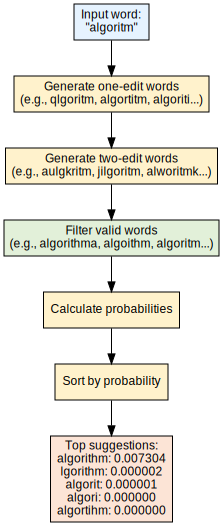

In [26]:
# Create and display the flowchart
create_spelling_correction_flowchart(test_word, one_edits, two_edits, valid_words, corrections)

In [18]:
# Save the word probabilities and vocabulary using joblib
dump(probs, '/content/drive/MyDrive/ML/Correct spelling/word-probability-spellings.joblib')
dump(vocab, '/content/drive/MyDrive/ML/Correct spelling/vocab-spellings.joblib')

print("\nWord probabilities and vocabulary saved successfully using joblib.")


Word probabilities and vocabulary saved successfully using joblib.
